In [39]:
import sys
from pathlib import Path
# add project_root/src to sys.path
src_folder = Path.cwd().parent       # this is project_root/src
sys.path.insert(0, str(src_folder))
# Now Python knows to look inside project_root/src for modules.
from util import filter
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng(42) #random number generator

params = {
    # —— Glucose subsystem (eq. 27) —————————————————————
    "PG"      : 0.022,      # 1/min
    "Si"      : 1.2e-4,     # 1/min
    "alpha_G" : 1.0,        # 1/(mU·L⁻¹)
    "EGPb"    : 1.27,       # mmol/min  (0.0161 mmol⋅kg⁻¹⋅min⁻¹ × 79 kg)
    "CNS"     : 1.16,       # mmol/min
    "VG"      : 10.0,       # L

    # —— Insulin transport (eqs. 28–29) —————————————————
    "nI"      : 0.157,      # 1/min
    "nC"      : 0.0159,     # 1/min
    "nK"      : 0.0165,     # 1/min
    "nL"      : 0.003,      # 1/min
    "alpha_I" : 0.18,       # 1/(mU·L⁻¹)
    "VI"      : 11.0,       # L
    "xL"      : 0.60,       # unitless

    # —— Endogenous insulin (eq. 32) ——————————————————
    "k1"      : 210,        # mU/min
    "k2"      : 300,        # mU/L
    "k3"      : 0.007,      # unitless

    # —— Stomach / gut (eqs. 30–31) ————————————————
    "d1"      : 0.05,       # 1/min
    "d2"      : 0.06,       # 1/min
    "Pmax"    : 1.50,       # mmol/min
    "PN"      : 0.011,      # mmol/min  (0.2 mg/min ÷ 180 mg/mmol)

    # —— Interstitial glucose (eq. 34) ——————————————
    "beta1"   : 0.002,      # 1/min
    "beta2"   : 0.02,       # 1/min

    # —— Constant insulin infusion ——————————————————
    "uex"     : 58.91       # mU/min
}

def D_of_t(t_min):
    meal_starts = (7*60, 14*60, 21*60)      # min after midnight
    D_rate = 5 * (1000/180) / 40          # = 5.556 mmol/min
    return sum(D_rate for m in meal_starts if m <= t_min < m + 40)


def glucose_insulin_model(t, x, p):
    BG, IG, Q, I, P1, P2 = x
    P = p["PN"] + min(p["d2"] * P2, p["Pmax"])
    uen = p["k1"] * np.exp(-I / p["k2"]) + p["k3"]

    dBG = ( -p["PG"]*BG
            - p["Si"]*BG*Q/(1 + p["alpha_G"]*Q)
            + P
            + p["EGPb"]
            - p["CNS"] ) / p["VG"]

    dQ  = p["nI"]*(I - Q) - p["nC"]*Q/(1 + p["alpha_G"]*Q)

    dI  = ( -p["nK"]*I
            - p["nL"]*I/(1 + p["alpha_I"]*I)
            - p["nI"]*(I - Q)
            + p["uex"]/p["VI"]
            + (1 - p["xL"]) * uen / p["VI"] )

    dP1 = -p["d1"]*P1 + D_of_t(t)        # D_of_t defined below
    dP2 = -min(p["d2"]*P2, p["Pmax"]) + p["d1"]*P1
    dIG = p["beta1"]*BG - p["beta2"]*IG

    return [dBG, dIG, dQ, dI, dP1, dP2]


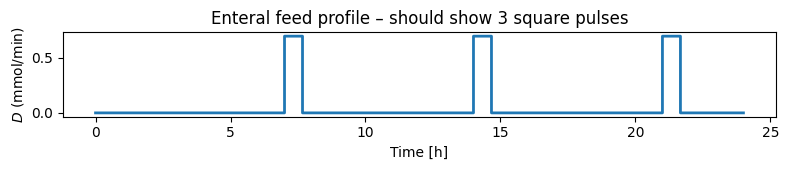

In [20]:
# ---- Sanity check: plot D(t) alone --------------------------------------
t_meal   = np.arange(0, 24*60+1)          # 48 h, 1-min grid
D_trace  = [D_of_t(t) for t in t_meal]

plt.figure(figsize=(8,1.8))
plt.step(t_meal/60, D_trace, where='post', lw=2)
plt.ylabel('$D$ (mmol/min)')
plt.xlabel('Time [h]')
plt.title('Enteral feed profile – should show 3 square pulses')
plt.tight_layout(); plt.show()


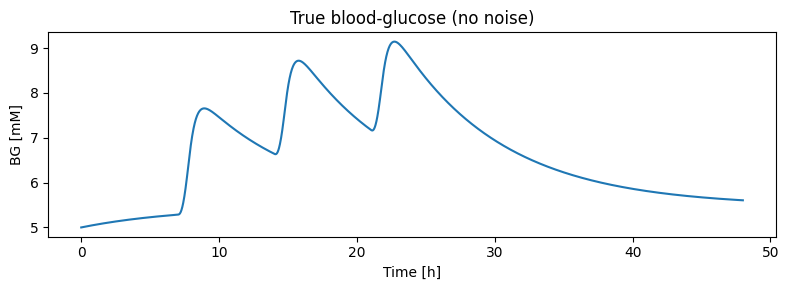

In [ ]:
t_end = 48 * 60        # minutes (48 h)
dt    = 1
ts    = np.arange(0, t_end + dt, dt)

# Initial state vector: [BG, IG, Q, I, P1, P2]
x0 = np.array([5.0, 5.0, 74.0, 108.58, 0.0, 0.0])

solver = ode(lambda t, x: glucose_insulin_model(t, x, params))\
           .set_integrator('dopri5')
solver.set_initial_value(x0, 0)

xs = np.zeros((len(ts), 6))
xs[0] = x0
for k in range(1, len(ts)):
    xs[k] = solver.integrate(ts[k])

# Plot the true BG trajectory
plt.figure(figsize=(8, 3))
plt.plot(ts / 60, xs[:, 0], label='True BG')
plt.xlabel('Time [h]')
plt.ylabel('BG [mM]')
plt.title('True blood-glucose (no noise)')
plt.tight_layout()
plt.show()


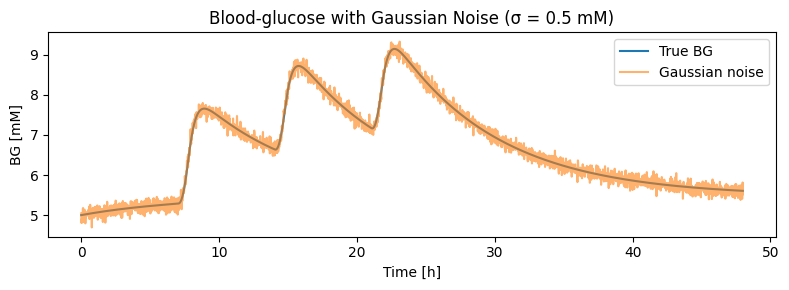

In [ ]:
bg_true = xs[:, 0]
time_hours = ts / 60

sigma_gaussian = 0.1  # standard deviation in mmol/L (adjust as needed)
noise_gaussian = rng.normal(loc=0.0, scale=sigma_gaussian, size=bg_true.shape)
bg_gauss_noisy = bg_true + noise_gaussian

plt.figure(figsize=(8, 3))
plt.plot(time_hours, bg_true, label='True BG', color='tab:blue')
plt.plot(time_hours, bg_gauss_noisy, label='Gaussian noise', color='tab:orange', alpha=0.6)
plt.xlabel('Time [h]')
plt.ylabel('BG [mM]')
plt.title('Blood-glucose with Gaussian Noise (σ = 0.1 mM)')
plt.legend()
plt.tight_layout()
plt.show()

add non-Gaussian noise ?

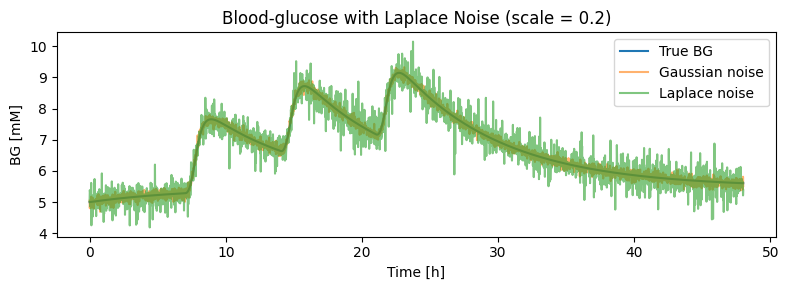

In [29]:
scale_laplace = 0.2  # scale parameter for Laplace (equivalent to σ for comparison)
noise_laplace = rng.laplace(loc=0.0, scale=scale_laplace, size=bg_true.shape)
bg_laplace_noisy = bg_true + noise_laplace

plt.figure(figsize=(8, 3))
plt.plot(time_hours, bg_true, label='True BG', color='tab:blue')
plt.plot(time_hours, bg_gauss_noisy, label='Gaussian noise', color='tab:orange', alpha=0.6)
plt.plot(time_hours, bg_laplace_noisy, label='Laplace noise', color='tab:green', alpha=0.6)
plt.xlabel('Time [h]')
plt.ylabel('BG [mM]')
plt.title('Blood-glucose with Laplace Noise (scale = 0.2)')
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
import os, sys
SRC_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))  

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from util.filter import KalmanFilter, KalmanNetFilter, ParticleFilter



ImportError: cannot import name 'KalmanFilter' from 'util.filter' (/home/ash/Desktop/kalman-net/src/util/filter.py)

In [44]:
import os, sys

# Suppose your Jupyter cwd is: /home/ash/Desktop/kalman-net/src/notebooks
SRC_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))  
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

import util.filter as f
print("util.filter __file__ →", f.__file__)
print("dir(util.filter) →", [n for n in dir(f) if not n.startswith('_')])


util.filter __file__ → /home/ash/Desktop/kalman-net/src/util/filter.py
dir(util.filter) → []


In [45]:
import os, sys

# 1) Make sure we add “src” (the parent of util/) to sys.path
SRC_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

# 2) Import util.filter and print its location + public names
import util.filter as f
print("Loaded util.filter from:", f.__file__)
print("Public names:", [n for n in dir(f) if not n.startswith('_')])


Loaded util.filter from: /home/ash/Desktop/kalman-net/src/util/filter.py
Public names: []
